# Data Preprocessing

In [1]:
import nltk

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt

In [2]:
## Download Data
nltk.download("treebank")

## Load data
from nltk.corpus import treebank
data = treebank.tagged_sents()
print(f"Number of sentences: {len(data)}")

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\raj\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


Number of sentences: 3914


In [3]:
## Train-Test Split

# train_data = data[:3500]
# test_data = data[3500:]

X_train = [[word for word, tag in sentence] for sentence in data[:3500]]
y_train = [[tag for word, tag in sentence] for sentence in data[:3500]]

X_test = [[word for word, tag in sentence] for sentence in data[3500:]]
y_test = [[tag for word, tag in sentence] for sentence in data[3500:]]

In [4]:
sent_vocab = set([word.lower() for sentence in X_train for word in sentence])
tag_vocab = set([tag.lower() for sentence in y_train for tag in sentence])

sent_vocab.add("<OOV>")
sent_vocab.add("<PAD>")
sent_vocab = sorted(sent_vocab)

idx_to_word_map = {idx: word for idx, word in enumerate(sent_vocab)}
word_to_idx_map = {word: idx for idx, word in enumerate(sent_vocab)}


tag_vocab = sorted(tag_vocab)
tag_vocab.append("<PAD>")
idx_to_tag_map = {idx: tag for idx, tag in enumerate(tag_vocab)}
tag_to_idx_map = {tag: idx for idx, tag in enumerate(tag_vocab)}

In [5]:
X_train = [[word_to_idx_map.get(word.lower(), word_to_idx_map["<OOV>"]) for word in sentence] for sentence in X_train]
y_train = [[tag_to_idx_map[tag.lower()] for tag in sentence] for sentence in y_train]

X_test = [[word_to_idx_map.get(word.lower(), word_to_idx_map["<OOV>"]) for word in sentence] for sentence in X_test]
y_test = [[tag_to_idx_map[tag.lower()] for tag in sentence] for sentence in y_test]

In [6]:
max_sent_len = max(X_train, key=len)
print(f"maximum sentence length: {len(max_sent_len)}")

maximum sentence length: 271


In [7]:
X_train = pad_sequence([torch.tensor(sentence) for sentence in X_train], batch_first=True, padding_value=word_to_idx_map["<PAD>"])
y_train = pad_sequence([torch.tensor(sentence) for sentence in y_train], batch_first=True, padding_value=tag_to_idx_map["<PAD>"])

X_test = pad_sequence([torch.tensor(sentence) for sentence in X_test], batch_first=True, padding_value=word_to_idx_map["<PAD>"])
y_test = pad_sequence([torch.tensor(sentence) for sentence in y_test], batch_first=True, padding_value=tag_to_idx_map["<PAD>"])

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([3500, 271]),
 torch.Size([3500, 271]),
 torch.Size([414, 58]),
 torch.Size([414, 58]))

# Build Model

In [8]:
## Model Definition
## First, let's define the hyperparameters for our model.
# ## Input and output dimensions
# VOCAB_SIZE = len(sent_vocab)
# OUTPUT_SIZE = len(tag_vocab)
# ## Embedding dimensions
# EMBEDDING_DIM = 100
# ## Hidden Layer dimensions
# HIDDEN_DIM = 128
# ## Number of layers
# N_LAYERS = 2
# ## Dropout probability
# DROPOUT = 0.25
# ## Learning Rate
# LEARNING_RATE = 1e-3
# ## Number of epochs
# EPOCHS = 10
# ## Batch Size
# BATCH_SIZE = 256


class LSTMTagger(nn.Module):
    def __init__(self, input_size, output_size, embedding_dim, hidden_dim, n_layers, dropout = 0.25):
        super(LSTMTagger, self).__init__()
        ## Input Shape: Batch, Sequence Length
        self.word_embeddings = nn.Embedding(num_embeddings = input_size, embedding_dim = embedding_dim, padding_idx = word_to_idx_map["<PAD>"])
        ## Input Shape: Batch, Sequence Length, Embedding Dimensions
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim, num_layers = n_layers, dropout = dropout, batch_first = True,
                            bidirectional = True)
        ## Input Shape: Batch, Sequence Length, Hidden Dimensions
        self.dropout = nn.Dropout(dropout)
        self.hidden2tag = nn.Linear(hidden_dim * 2, output_size)
        ## Output Shape: Batch, Sequence Length, Output Dimensions
    
    def forward(self, sentence):
        ## Input Shape: Batch, Sequence Length
        embeds = self.word_embeddings(sentence)
        ## Input Shape: Batch, Sequence Length, Embedding Dimensions
        lstm_out, _ = self.lstm(embeds)
        ## Input Shape: Batch, Sequence Length, Hidden Dimensions
        lstm_out = self.dropout(lstm_out)
        tag_space = self.hidden2tag(lstm_out)
        ## Input Shape: Batch, Sequence Length, Output Dimensions
        tag_scores = F.log_softmax(tag_space, dim = 2)
        ## Output Shape: Batch, Sequence Length, Output Dimensions
        return tag_scores

In [9]:
## Training function 

def train(model, X_train, y_train, optimizer, criterion, batch_size = 256, epochs = 10):
    model.train()
    losses = []
    for epoch in range(epochs):
        for idx in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            batch_X = X_train[idx:idx + batch_size]
            batch_y = y_train[idx:idx + batch_size]
            tag_scores = model(batch_X)
            
            loss = criterion(tag_scores.view(-1, tag_scores.shape[2]), batch_y.view(-1))
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"Epoch: {epoch}, Loss: {losses[-1]}")
    plt.plot(losses)

Epoch: 0, Loss: 2.9665117263793945
Epoch: 1, Loss: 0.5645630359649658
Epoch: 2, Loss: 0.4423278272151947
Epoch: 3, Loss: 0.37639936804771423
Epoch: 4, Loss: 0.3739485740661621
Epoch: 5, Loss: 0.35844898223876953
Epoch: 6, Loss: 0.3352885842323303
Epoch: 7, Loss: 0.311938613653183
Epoch: 8, Loss: 0.2965640127658844
Epoch: 9, Loss: 0.28732535243034363


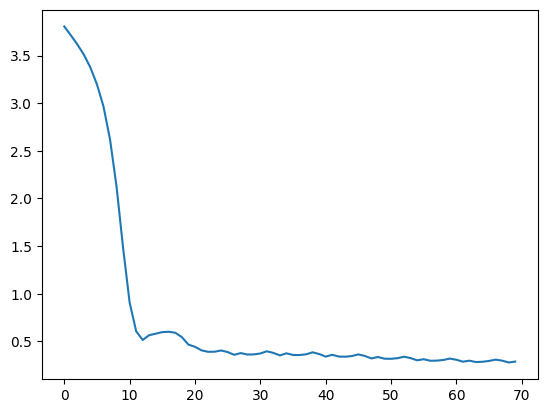

In [11]:
## Model Initialization

## Input and output dimensions
VOCAB_SIZE = len(sent_vocab)
OUTPUT_SIZE = len(tag_vocab)
## Embedding dimensions
EMBEDDING_DIM = 100
## Hidden Layer dimensions
HIDDEN_DIM = 128
## Number of layers
N_LAYERS = 2
## Dropout probability
DROPOUT = 0.25
## Learning Rate
LEARNING_RATE = 1e-3
## Number of epochs
EPOCHS = 100
## Batch Size
BATCH_SIZE = 512

model = LSTMTagger(input_size = VOCAB_SIZE, output_size = OUTPUT_SIZE, embedding_dim = EMBEDDING_DIM, 
                   hidden_dim = HIDDEN_DIM, n_layers = N_LAYERS, dropout = DROPOUT)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

train(model, X_train, y_train, optimizer, criterion, batch_size = BATCH_SIZE, epochs = EPOCHS)

# Test Model

In [14]:
## Testing function

def test(model, data, targets, batch_size = 256, verbose = False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for idx in range(0, len(data), batch_size):
            batch_X = data[idx:idx + batch_size]
            batch_y = targets[idx:idx + batch_size]
            tag_scores = model(batch_X)
            _, predicted = torch.max(tag_scores, 2)
            total += batch_y.nelement()
            correct += (predicted == batch_y).sum().item()
    if verbose:
        print(f"Total: {total}, Correct: {correct}, Accuracy: {correct / total}")
    return correct / total

In [23]:
training_accuracy = test(model, X_train, y_train, batch_size = BATCH_SIZE, verbose = True)
testing_accuracy = test(model, X_test, y_test, batch_size = BATCH_SIZE, verbose = True)

Total: 948500, Correct: 942655, Accuracy: 0.9938376383763837
Total: 24012, Correct: 22534, Accuracy: 0.9384474429451941


In [1]:
## Save Model with current_date
import datetime

current_date = datetime.datetime.now().strftime("%Y-%m-%d")
model_path = f"POS_Tagger{current_date}.pth"
torch.save(model.state_dict(), model_path)

NameError: name 'torch' is not defined

# Use Model

In [42]:
## Function to get POS Tags for a sentence

def get_pos_tags(model, sentence, word_to_idx_map, idx_to_tag):
    sentence = nltk.word_tokenize(sentence)
    model.eval()
    with torch.no_grad():
        sentence = [word_to_idx_map.get(word.lower(), word_to_idx_map["<OOV>"]) for word in sentence]
        sentence = torch.tensor(sentence).unsqueeze(0)
        tag_scores = model(sentence)
        _, predicted = torch.max(tag_scores, 2)
        return [idx_to_tag[idx_tensor.item()] for idx_tensor in predicted[0]]

In [46]:
example = "The quick brown fox jumps over the lazy dog."
ex_tags = get_pos_tags(model, example, word_to_idx_map, idx_to_tag_map)
print(list(zip(nltk.word_tokenize(example), ex_tags)))

[('The', 'dt'), ('quick', 'nn'), ('brown', 'nnp'), ('fox', 'vbn'), ('jumps', 'nns'), ('over', 'in'), ('the', 'dt'), ('lazy', 'nns'), ('dog', 'vbp'), ('.', '.')]
